# Build A RAG chatbot using Ollama Serve LLM locally and ChromaDB

## Goal:

Create an app that allows users to input URLs, pose questions, and receive answers based on the content of the specified documents

## App:

The app leverages Ollama, a tool that allows running large language models (LLMs) locally, along with the Mistral 7B open-source model for text embeddings and retrieval-based question answering. 

## Why Ollama?
- Streamlined tool for running open-source LLMs locally, including Mistral and Llama 2. 
- Bundles model weights, configurations, and datasets into a unified package managed by a Model file.
- Supports a variety of LLMs including LLaMA-2, uncensored LLaMA, CodeLLaMA, Falcon, Mistral, Vicuna model, WizardCoder, and Wizard uncensored.
- Run LLMs locally, which means your data stays safe and secure

## App Overview:

On a fundamental level, the workflow of the app:
1. A user submits a list of URLs (one per line) and enters a question.
2. The app processes the input, fetching the content from the provided URLs.
3. The text content is split into manageable chunks.
4. These chunks are converted into embeddings using the mistral model and stored in a vector database ( Chroma ).
5. The user's question is processed through a Retrieval-Augmented Generation (RAG) pipeline, which retrieves relevant document sections and generates an answer using the Mistral 7B model.

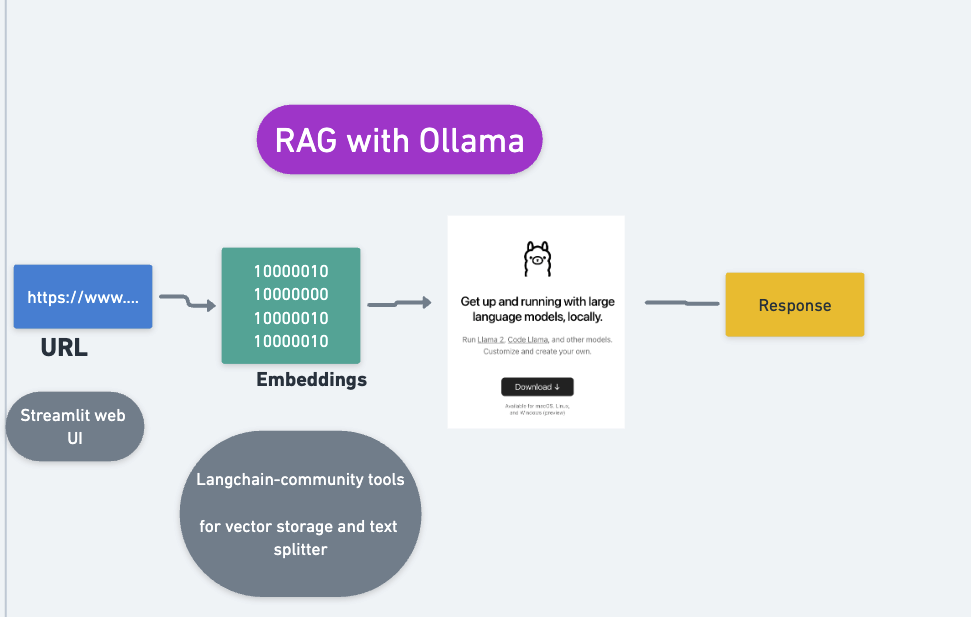

## Prerequestie:

### Download Ollama & run the open-source LLM
First, follow these instructions to set up and run a local Ollama instance:

- Download and install Ollama onto the available supported platforms (including Windows Subsystem for Linux)
- Download the model you want to use Ollama run <mistral>
- Fetch available LLM model via ollama pull <mistral>

## Setting Up the Environment
Before diving into the code, ensure you have the necessary libraries installed. If not, you can install them using pip:

pip install streamlit langchain_community

We'll import the required modules from Streamlit and LangChain community libraries. 

Streamlit is used for creating the web app interface, while LangChain provides tools for text splitting, embeddings, vector storage, and retrieval-based question answering.

In [1]:
import streamlit as st

from langchain_community.document_loaders import WebBaseLoader

from langchain_community.vectorstores import Chroma

from langchain_community import embeddings

from langchain_community.llms import Ollama

from langchain_core.runnables import RunnablePassthrough

from langchain_core.output_parsers import StrOutputParser

from langchain_core.prompts import ChatPromptTemplate

from langchain.text_splitter import CharacterTextSplitter 

## The Main Function: process_input

The process_input function is the core of our app. It takes a list of URLs and a query text as inputs and performs the following steps:

1. Load Documents: 

Convert the input string of URLs into a list. It then uses the WebBaseLoader from LangChain to fetch the content from each URL and load it into a list of documents.

2. Split Documents into Chunks: 

This CharacterTextSplitter is used to divide the document text into smaller, manageable chunks for efficient processing. This is crucial for handling large texts.

3. Select Embeddings: 

The OllamaEmbeddings model from the LangChain community is initialized to generate embeddings for the text chunks.

4. Create a Vector Store: 

The Chroma vector store is used to store the document embeddings, facilitating efficient retrieval.

5. Create Retriever Interface: 

The vector store is transformed into a retriever, which can fetch relevant document sections based on queries.

6. Perform the RAG: 

This step sets up the Retrieval-Augmented Generation (RAG) pipeline. First, a template is defined for formatting the context and question. Then, a ChatPromptTemplate is created from this template, and a chain is assembled using the retriever, prompt, Ollama language model, and a string output parser. This chain is responsible for generating the final answer based on the retrieved context and the user's question.

7. Run Query: 

Finally, the RAG chain is invoked with the user's question, and the generated answer is returned.

In [2]:
 # URL processing
def process_input(urls, question):
    model_local = Ollama(model="mistral")
    
    # Convert string of URLs to list
    urls_list = urls.split("\n")
    docs = [WebBaseLoader(url).load() for url in urls_list]
    docs_list = [item for sublist in docs for item in sublist]
    
    #split the text into chunks
    
    text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=7500, chunk_overlap=100)
    doc_splits = text_splitter.split_documents(docs_list)
    
    #convert text chunks into embeddings and store in vector database

    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        collection_name="rag-chroma",
        embedding=embeddings.ollama.OllamaEmbeddings(model='mistral'),
    )
    retriever = vectorstore.as_retriever()
    
    #perform the RAG 
    
    after_rag_template = """Answer the question based only on the following context:
    {context}
    Question: {question}
    """
    after_rag_prompt = ChatPromptTemplate.from_template(after_rag_template)
    after_rag_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | after_rag_prompt
        | model_local
        | StrOutputParser()
    )
    return after_rag_chain.invoke(question) 

In [5]:
# st.title("Document Query with Ollama")
# st.write("Enter URLs (one per line) and a question to query the documents.")

# # Input fields
# urls = st.text_area("Enter URLs separated by new lines", height=150)
# question = st.text_input("Question")

# # Button to process input
# if st.button('Query Documents'):
#     with st.spinner('Processing...'):
#         answer = process_input(urls, question)
#         st.text_area("Answer", value=answer, height=300, disabled=True) 

In [6]:
urls = "https://www.linkedin.com/pulse/how-build-rag-chatbot-using-ollama-serve-llms-locally-sri-laxmi-beapc/?utm_source=share&utm_medium=member_ios&utm_campaign=share_via)"
question = "What is the title"

answer = process_input(urls, question)
answer

Number of requested results 4 is greater than number of elements in index 2, updating n_results = 2


' The title is "How to build a RAG chatbot using Ollama - Serve LLMs locally".'

Reference:

- Article:
https://www.linkedin.com/pulse/how-build-rag-chatbot-using-ollama-serve-llms-locally-sri-laxmi-beapc/?utm_source=share&utm_medium=member_ios&utm_campaign=share_via

- Youtube Explanation:
https://www.youtube.com/watch?v=kfbTZFAikcE